In [9]:
## Momentum(MA) & Overreact(RSI)

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import math

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)


## 퀀트함수 ## 절대경로 참조
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
from library.quant_functions import anal_funcs, data_funcs

## Func

In [2]:
# 빈도로 상대적강도지수를 산출하는 함수
def get_rsi(df, t=14):
    temp_df = df.diff()
    rsi_df = pd.DataFrame(columns=temp_df.columns, index=temp_df.index)
    for j in range(len(temp_df.columns)):

        rsi_ls = []
        for i in range(1, len(temp_df)+1):
            temp = temp_df[temp_df.columns[j]][i-t:i]
            pi = ((temp + abs(temp))/2).mean()
            nd = abs(((temp - abs(temp))/2).mean())
            if nd == 0:
                rs = np.inf
            else:
                rs = pi/nd

            rsi = 100 - 100/(1+rs)

            rsi_ls.append(rsi)
        rsi_df[rsi_df.columns[j]] = rsi_ls
    return rsi_df

## Data

In [3]:
Ticker = 'QQQ'
Ticker_bm = 'TLT'

df = data_funcs.get_merged_df(Ticker, Ticker_bm).dropna()
df_ori = df[[Ticker]]
df_bm = df[[Ticker_bm]]

[*********************100%***********************]  2 of 2 completed


## Opt

In [5]:
opt_dict = []
for r_seed in range(1,7):
    r = 0.01 * r_seed
    
    ## dataset = df_ori.copy()
    dataset = df_ori[:-250*5].copy()

    dataset['RSI'] = get_rsi(dataset[[Ticker]])
    dataset['M20'] = dataset[Ticker].rolling(20).mean()
    dataset['M60'] = dataset[Ticker].rolling(60).mean()
    dataset['M120'] = dataset[Ticker].rolling(120).mean()
    dataset = dataset.dropna()

    dataset['temp'] = dataset[Ticker] - dataset['M20']
    dataset['temp'] = (dataset['temp'] >= 0)
    dataset['T20'] = 0
    dataset['T20'][dataset['temp'] != dataset['temp'].shift(1)] = 1

    dataset['temp'] = dataset[Ticker] - dataset['M60']
    dataset['temp'] = (dataset['temp'] >= 0)
    dataset['T60'] = 0
    dataset['T60'][dataset['temp'] != dataset['temp'].shift(1)] = 1

    dataset['temp'] = dataset[Ticker] - dataset['M120']
    dataset['temp'] = (dataset['temp'] >= 0)
    dataset['T120'] = 0
    dataset['T120'][dataset['temp'] != dataset['temp'].shift(1)] = 1

    dataset['TRSI'] = 0
    dataset['TRSI'][(dataset['RSI'] < 35)&(dataset[Ticker] <= dataset['T120'])] = 1

    dataset = dataset[1:]

    dataset['T20_ratio'] = 0
    dataset['T20_ratio'][dataset['T20'] == 1] = r
    dataset['T20_ratio'][dataset['T20'].shift(1) == 1] = r

    dataset['T60_ratio'] = 0
    dataset['T60_ratio'][dataset['T60'] == 1] = r
    dataset['T60_ratio'][dataset['T60'].shift(1) == 1] = r
    dataset['T60_ratio'][dataset['T60'].shift(2) == 1] = r

    dataset['T120_ratio'] = 0
    dataset['T120_ratio'][dataset['T120'] == 1] = r
    dataset['T120_ratio'][dataset['T120'].shift(1) == 1] = r
    dataset['T120_ratio'][dataset['T120'].shift(2) == 1] = r
    dataset['T120_ratio'][dataset['T120'].shift(3) == 1] = r
    dataset['T120_ratio'][dataset['T120'].shift(4) == 1] = r

    dataset['TRSI_ratio'] = 0
    dataset['TRSI_ratio'][dataset['TRSI'] == 1] = r*2
    dataset['TRSI_ratio'][dataset['TRSI'].shift(1) == 1] = r*2
    dataset['TRSI_ratio'][dataset['TRSI'].shift(2) == 1] = r*2
    dataset['TRSI_ratio'][dataset['TRSI'].shift(3) == 1] = r*2
    dataset['TRSI_ratio'][dataset['TRSI'].shift(4) == 1] = r*2

    dataset['ratio'] = (dataset['T20_ratio'] + dataset['T60_ratio'] + dataset['T120_ratio'] + dataset['TRSI_ratio'])
    
    for rsi in range(75, 95):
        ## 누적 매입하고 RSI가 임계치 이상이면, 리셋
        target_df = dataset.copy()

        target_df['T_sell'] = 0
        target_df['T_sell'][target_df['RSI'] >= rsi] = 1

        target_df['cum_ratio'] = target_df['ratio'].cumsum()
        for i in target_df[target_df['T_sell'] == 1].index:
            target_df['cum_ratio'][target_df.index >= i] = target_df['ratio'][target_df.index >= i].cumsum()
        target_df['cum_ratio'][target_df['cum_ratio'] >= 1] = 1
        target_df['ratio'][target_df['cum_ratio'] >= 1] = 0

        ## 활용 데이터만 남김
        ratio_df = target_df[[Ticker, 'cum_ratio', 'ratio', 'T_sell']].copy()
        ratio_df[Ticker_bm] = df_bm[Ticker_bm].copy()
        ratio_df['CASH'] = 1

        ## 누적자산가치 계산
        ## 자산 투자 비중 변동시 데이터 프레임 분할
        date_idx = ratio_df[ratio_df['cum_ratio'] != ratio_df['cum_ratio'].shift()].index
        df_dict = []
        for i in range(len(date_idx)-1):
            temp_df = ratio_df[(ratio_df.index >= date_idx[i])&(ratio_df.index <= date_idx[i+1])]
            df_dict.append(temp_df)
        df_dict.append(ratio_df[(ratio_df.index >= date_idx[-1])])

        ## 누적자산가치 계산
        prev_val = 1
        temp_series = pd.Series()
        ## test_dict = []
        ## test_dict2 = []
        ## test_dict3 = []
        for i in range(len(df_dict)):    
            temp = df_dict[i][[Ticker, Ticker_bm]]/np.array(df_dict[i][[Ticker, Ticker_bm]])[0]
            ratio = ((df_dict[i]['cum_ratio'][0], 1 - df_dict[i]['cum_ratio'][0]))
            temp_ = (temp * ratio).sum(axis=1)*prev_val    
            ## test_dict.append(temp)
            ## test_dict2.append(prev_val)
            prev_val = temp_[-1]   
            ## test_dict3.append(prev_val)    
            temp_series = temp_series.append(temp_[1:])


        res_df = ratio_df.copy()

        res_df['strategy'] = temp_series
        res_df['strategy'][0] = 1

        ## sortino ratio
        eval_res = anal_funcs.get_Vol_report(res_df[[Ticker, Ticker_bm, 'strategy']], 'a', unit='daily')
        opt_dict.append((r, rsi, eval_res['Sortino_Ratio'][2], eval_res['Return'][2]))
    
opt_df = pd.DataFrame(opt_dict, columns=['Ratio', 'RSI', 'SR', 'YRR'])

In [92]:
opt_df_5 = opt_df[opt_df['YRR'] >= 0.2]

In [115]:
opt_df_5[opt_df_5['YRR'] == opt_df_5['YRR'].max()]

,Ratio,RSI,SR,YRR
104,0.06,79,4.26,15.58


<AxesSubplot:xlabel='RSI', ylabel='SR'>

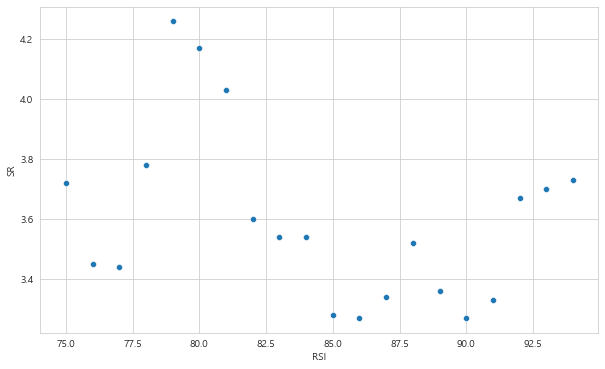

In [116]:
sns.scatterplot(data=opt_df_5[opt_df_5['Ratio'] == 0.06], x = 'RSI', y='SR')

## Report

In [118]:
r = 0.06
rsi = 79

In [119]:
## dataset = df_ori.copy()
dataset = df_ori[:].copy()

dataset['RSI'] = get_rsi(dataset[[Ticker]])
dataset['M20'] = dataset[Ticker].rolling(20).mean()
dataset['M60'] = dataset[Ticker].rolling(60).mean()
dataset['M120'] = dataset[Ticker].rolling(120).mean()
dataset = dataset.dropna()

dataset['temp'] = dataset[Ticker] - dataset['M20']
dataset['temp'] = (dataset['temp'] >= 0)
dataset['T20'] = 0
dataset['T20'][dataset['temp'] != dataset['temp'].shift(1)] = 1

dataset['temp'] = dataset[Ticker] - dataset['M60']
dataset['temp'] = (dataset['temp'] >= 0)
dataset['T60'] = 0
dataset['T60'][dataset['temp'] != dataset['temp'].shift(1)] = 1

dataset['temp'] = dataset[Ticker] - dataset['M120']
dataset['temp'] = (dataset['temp'] >= 0)
dataset['T120'] = 0
dataset['T120'][dataset['temp'] != dataset['temp'].shift(1)] = 1

dataset['TRSI'] = 0
dataset['TRSI'][(dataset['RSI'] < 35)&(dataset[Ticker] <= dataset['T120'])] = 1

dataset = dataset[1:]

dataset['T20_ratio'] = 0
dataset['T20_ratio'][dataset['T20'] == 1] = r
dataset['T20_ratio'][dataset['T20'].shift(1) == 1] = r

dataset['T60_ratio'] = 0
dataset['T60_ratio'][dataset['T60'] == 1] = r
dataset['T60_ratio'][dataset['T60'].shift(1) == 1] = r
dataset['T60_ratio'][dataset['T60'].shift(2) == 1] = r

dataset['T120_ratio'] = 0
dataset['T120_ratio'][dataset['T120'] == 1] = r
dataset['T120_ratio'][dataset['T120'].shift(1) == 1] = r
dataset['T120_ratio'][dataset['T120'].shift(2) == 1] = r
dataset['T120_ratio'][dataset['T120'].shift(3) == 1] = r
dataset['T120_ratio'][dataset['T120'].shift(4) == 1] = r

dataset['TRSI_ratio'] = 0
dataset['TRSI_ratio'][dataset['TRSI'] == 1] = r*2
dataset['TRSI_ratio'][dataset['TRSI'].shift(1) == 1] = r*2
dataset['TRSI_ratio'][dataset['TRSI'].shift(2) == 1] = r*2
dataset['TRSI_ratio'][dataset['TRSI'].shift(3) == 1] = r*2
dataset['TRSI_ratio'][dataset['TRSI'].shift(4) == 1] = r*2

dataset['ratio'] = (dataset['T20_ratio'] + dataset['T60_ratio'] + dataset['T120_ratio'] + dataset['TRSI_ratio'])

In [120]:
## 누적 매입, RSI 임계점 도달시 리셋
target_df = dataset.copy()

target_df['T_sell'] = 0
target_df['T_sell'][target_df['RSI'] >= rsi] = 1

target_df['cum_ratio'] = target_df['ratio'].cumsum()
for i in target_df[target_df['T_sell'] == 1].index:
    target_df['cum_ratio'][target_df.index >= i] = target_df['ratio'][target_df.index >= i].cumsum()
target_df['cum_ratio'][target_df['cum_ratio'] >= 1] = 1
target_df['ratio'][target_df['cum_ratio'] >= 1] = 0

## 활용 데이터만 남김
ratio_df = target_df[[Ticker, 'cum_ratio', 'ratio', 'T_sell']].copy()
ratio_df[Ticker_bm] = df_bm[Ticker_bm].copy()
ratio_df['CASH'] = 1

## 누적자산가치 계산
## 자산 투자 비중 변동시 데이터 프레임 분할
date_idx = ratio_df[ratio_df['cum_ratio'] != ratio_df['cum_ratio'].shift()].index
df_dict = []
for i in range(len(date_idx)-1):
    temp_df = ratio_df[(ratio_df.index >= date_idx[i])&(ratio_df.index <= date_idx[i+1])]
    df_dict.append(temp_df)
df_dict.append(ratio_df[(ratio_df.index >= date_idx[-1])])

## 누적자산가치 계산
prev_val = 1
temp_series = pd.Series()
## test_dict = []
## test_dict2 = []
## test_dict3 = []
for i in range(len(df_dict)):    
    temp = df_dict[i][[Ticker, Ticker_bm]]/np.array(df_dict[i][[Ticker, Ticker_bm]])[0]
    ratio = ((df_dict[i]['cum_ratio'][0], 1 - df_dict[i]['cum_ratio'][0]))
    temp_ = (temp * ratio).sum(axis=1)*prev_val    
    ## test_dict.append(temp)
    ## test_dict2.append(prev_val)
    prev_val = temp_[-1]   
    ## test_dict3.append(prev_val)    
    temp_series = temp_series.append(temp_[1:])

res_df = ratio_df.copy()
res_df['strategy'] = temp_series
res_df['strategy'][0] = 1

## sortino ratio
eval_res = anal_funcs.get_Vol_report(res_df[[Ticker, Ticker_bm, 'strategy']], 'a', unit='daily', rf=1)

In [121]:
eval_res

,Return,Volatility,Volatility(Down),Residual,Beta,Sharpe_Ratio,Sortino_Ratio,Trainer_Ratio,Jensen_Alpha,Info_Ratio
Ticker,,,,,,,,,,
QQQ,14.32,5.27,3.58,0.00,1.00,2.53,3.72,13.32,-0.00,NaN
TLT,4.05,3.89,2.26,6.93,-0.17,0.78,1.35,-18.03,5.31,-1.48
strategy,15.79,4.95,3.42,3.50,0.82,2.99,4.33,18.11,3.91,0.42


In [122]:
res_df.tail(3)

,QQQ,cum_ratio,ratio,T_sell,TLT,CASH,strategy
Date,,,,,,,
2023-05-19,336.510010,0.48,0.0,0,101.099998,1,20.265071
2023-05-22,337.640015,0.48,0.0,0,100.739998,1,20.262367
2023-05-23,333.359985,0.48,0.0,0,101.029999,1,20.164019


<AxesSubplot:xlabel='Date'>

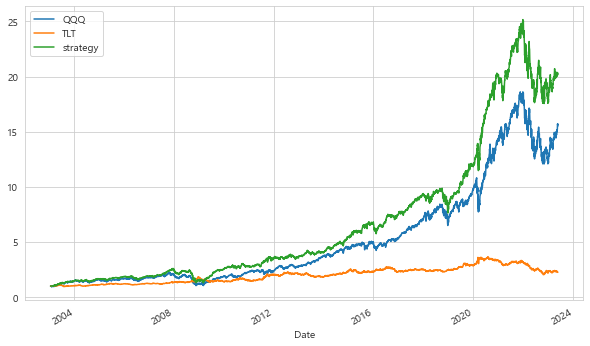

In [123]:
(res_df[[Ticker, Ticker_bm, 'strategy']]/np.array(res_df[[Ticker, Ticker_bm, 'strategy']])[0]).plot()

## FIRE

In [124]:
from sympy import Symbol, solve, solveset, Interval

In [125]:
s = 30000 * 1e4
k = 150000 *1e4

d = (dt.datetime(2028, 5, 31) - dt.datetime.now()).days
t = int(d/365) ## 연으로 변환

r = 0.43
c = 120*1e4*12

In [126]:
def cal_kap(s, c, r, t):
    '''
    s: seed, c: cashflow, r: return(Y), t: terms(Y)
    '''
    k = s*((1+r)**t) + c*((1-((1+r)**t)))/(1-(1+r))
    return(k)

In [127]:
def cal_ret(k, s, c, t):
    '''
    k: kapital, s: seed, c: cashflow, t: terms(Y)
    '''
    r=Symbol('r')
    equation = s*((1+r)**(t)) + c*((1-((1+r)**(t)))/(1-(1+r))) - k
    val = solveset(equation, r, Interval(0, 999))
    solve_r = float(list(val)[0])
    return(np.round(solve_r, 2))

In [128]:
def cal_term(k, s, c, r):
    '''
    k: kapital, s: seed, c: cashflow, t: terms(Y)
    '''
    t=Symbol('t')
    equation = s*((1+r)**(t)) + c*((1-((1+r)**(t)))/(1-(1+r))) - k
    val = solveset(equation, t, Interval(0, 999))
    solve_t = float(list(val)[0])
    return(np.round(solve_t, 2))

In [138]:
test_t = cal_term(k, s, c, r)
test_r = cal_ret(k, s, c, t)
test_t, test_r, cal_kap(s, c, test_r, t)//1e4

(1.45, 0.35, 148855.0)

In [139]:
temp_ls = []
for n in range(1, 2000):
    r = n*0.001
    gap = np.e**r - (1+r)
    temp_ls.append((r, gap))

In [140]:
temp_df = pd.DataFrame(temp_ls, columns=['r', 'gap'])

<AxesSubplot:xlabel='r', ylabel='gap'>

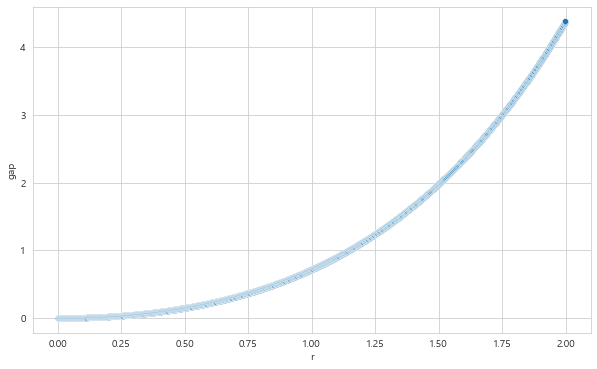

In [141]:
sns.scatterplot(data = temp_df, x = 'r', y = 'gap')